In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 5)

import warnings
warnings.filterwarnings('ignore')

# Boostings

Данные с которыми вы будете работать представляют из себя характеристики клиента страховой компании по которым нужно понять будет ли он заинтересован в страховке. Таким образом, страховая компания может более оптимально таргетить рекламу и выстраивать коммуникацию с клиентами, повышая конверсию.

**Описания колонок:**
- Gender - Male, Female
- Age - Возраст
- Driving_License - Наличие водительского удостоверения
- Region_Code - Область проживания
- Previously_Insured - Пользовался ли раньше услугами страховой компании
- Vehicle_Age - Возраст транспортного средства
- Vehicle_Damage - Попадало ли траспортное средство в ДТП
- Annual_Premium - Ежегодные вылаты клиента
- Policy_Sales_Channel - Политика распространения страховых услуг (через посредников, напрямую и т.д.)
- Vintage - Количество дней, в течение которых клиент был связан с компанией 


- **Response** - заинтересован в страховке 1, не откликнулся 0

In [2]:
data = pd.read_csv('vehicle_insurance.csv')

data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


**Задание 0.** Проведите небольшой EDA. Посмотрите на распределения некоторых колонок, на матрицу корреляций. Также проверьте баланс классов и посмотрите на распределение возраста транспортного средства в зависимости от response. \
Закодируйте признаки типа `object` с помощью `one-hot` кодирования.

P.S. некоторые не `object`колонки по смыслу очевидно являются категориальными. Так как мы будем строить ансамбли на основе деревьев, их можно оставить в первоначальном виде.

In [3]:
data.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,38.812900,0.997800,26.425400,0.443800,30609.649700,112.414400,155.560300,0.124700
std,15.514785,0.046855,13.153552,0.496856,16562.392967,53.975042,83.923849,0.330395
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24458.250000,30.000000,83.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31746.000000,136.000000,156.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39572.250000,152.000000,228.000000,0.000000
max,84.000000,1.000000,52.000000,1.000000,267698.000000,163.000000,299.000000,1.000000


Категориальные фичи, представленные вещественными: `'Driving_License'`, `'Region_Code'`, `'Previously_Insured'`, `'Policy_Sales_Channel'`. Оставляем без изменения, т.к. обучаем деревья.

In [4]:
# Пропуски

data.isna().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [5]:
# Корреляции

corr_matrix = data.corr()
corr_matrix

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
Age,1.000000,-0.081323,0.030638,-0.261456,0.081564,-0.576066,0.000030,0.113888
Driving_License,-0.081323,1.000000,0.004926,0.020464,-0.014338,0.044335,0.002704,0.011263
Region_Code,0.030638,0.004926,1.000000,-0.021270,-0.012213,-0.039733,-0.008527,0.010230
Previously_Insured,-0.261456,0.020464,-0.021270,1.000000,-0.005164,0.224719,0.022350,-0.333502
Annual_Premium,0.081564,-0.014338,-0.012213,-0.005164,1.000000,-0.123851,-0.008878,0.029839
Policy_Sales_Channel,-0.576066,0.044335,-0.039733,0.224719,-0.123851,1.000000,-0.006131,-0.146421
Vintage,0.000030,0.002704,-0.008527,0.022350,-0.008878,-0.006131,1.000000,-0.007187
Response,0.113888,0.011263,0.010230,-0.333502,0.029839,-0.146421,-0.007187,1.000000


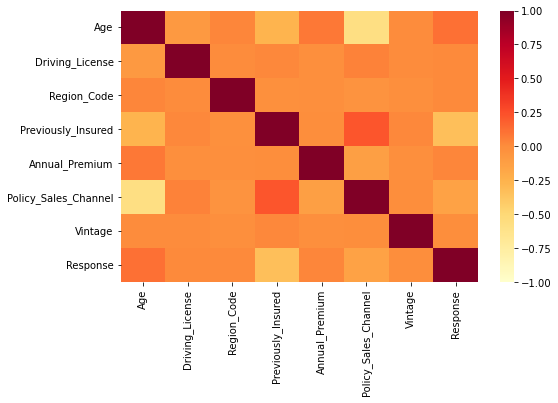

In [6]:
# HeatMap

sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap='YlOrRd')
plt.show()

In [7]:
# Баланс классов

data['Response'].value_counts()

0    8753
1    1247
Name: Response, dtype: int64

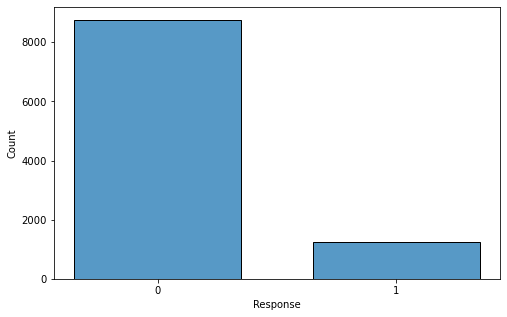

In [8]:
# Распределение классов

sns.histplot(data['Response'], bins=2, shrink=0.7, discrete=True)
plt.xticks([0, 1])
plt.show()

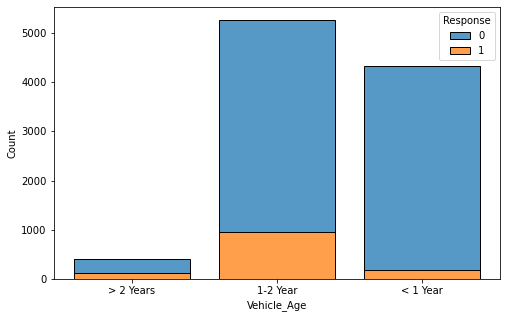

In [9]:
# Распределение возраста авто в зависимости от целевой переменной

sns.histplot(data, x='Vehicle_Age', hue='Response', element='bars', multiple='stack', shrink=0.8)
plt.show()

In [10]:
object_cols = data.loc[:, data.dtypes == object].columns
object_cols

Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')

In [11]:
# OneHotEncoding

for col in object_cols:
    ohe_df = pd.get_dummies(data[col], drop_first=True, prefix=col)
    data = pd.concat((data, ohe_df), axis=1)
    data = data.drop(col, axis=1)

In [12]:
data.head()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,44,1,28.0,0,40454.0,26.0,217,1,1,0,1,1
1,76,1,3.0,0,33536.0,26.0,183,0,1,0,0,0
2,47,1,28.0,0,38294.0,26.0,27,1,1,0,1,1
3,21,1,11.0,1,28619.0,152.0,203,0,1,1,0,0
4,29,1,41.0,1,27496.0,152.0,39,0,0,1,0,0


**Задание 1.** Обучите градиентный бустинг из sklearn на данных и замерьте accuracy и f1-score на тестовой выборке. В качестве параметров ансамбля установите `learning_rate = 1`, `random_state = 1`, `n_estimators = 100`. Изобразите ROC-кривую и посчитайте AUC, оцените качество классификации. (2б)

P.S. для всех прочих моделей в этом домашнем задании тоже фиксируйте `random_state = 1`. Как думаете, что может быть случайного в процедуре обучения градиентного бустинга?

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_curve, auc

X = data.drop('Response', axis=1)
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(learning_rate=1, n_estimators=100)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1)

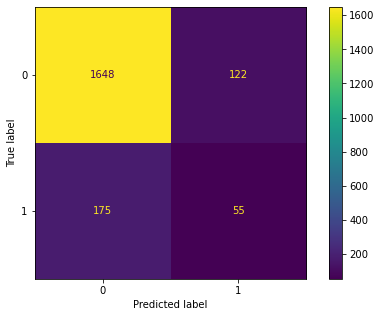

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, gbm.predict(X_test))
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [16]:
fpr, tpr, thrs = roc_curve(y_test, gbm.predict_proba(X_test)[:, 1])

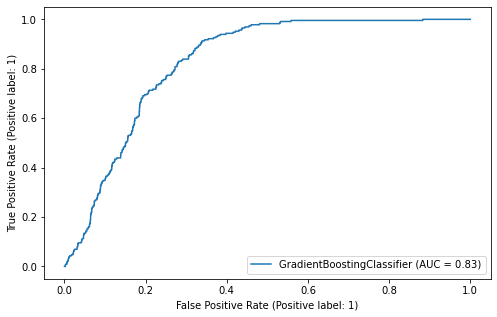

In [17]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(gbm, X_test, y_test)
plt.show()

In [18]:
print(f'GBM AUC ROC: {auc(fpr, tpr):.3}')

GBM AUC ROC: 0.828


In [19]:
print(classification_report(y_test, gbm.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.904     0.931     0.917      1770
           1      0.311     0.239     0.270       230

    accuracy                          0.852      2000
   macro avg      0.607     0.585     0.594      2000
weighted avg      0.836     0.852     0.843      2000



**Задание 2.** Переберите параметры `n_estimators` и `learning_rate` по двумерной сетке. При обучении в цикле сразу считайте f1-score на тестовой выборке и сохраняйте результат в матрицу. Для какого алгоритма качество окажется максимальным?

Постройте кривые для метрики f1-score в зависимости от числа шагов для нескольких learning_rate. Изобразите heatmap полученной матрицы. Сделайте вывод, как количество шагов влияет на качество совместно с различной скоростью обучения? (2б)

P.S. для подсчета f1-score передайте в функцию параметр `average='weighted'`, чтобы учитывался еще и баланс классов (вспомните микро/макро-усреднения).

In [20]:
# Задаем сетку параметров

n_estimators_list = [5, 10, 20, 50, 100, 200, 700, 1000]
learning_rate_list = [1, 0.1, 0.01]

In [21]:
scores = []

for n in n_estimators_list:
    for learning_rate in learning_rate_list:
        gbm = GradientBoostingClassifier(n_estimators=n, learning_rate=learning_rate, random_state=1)
        gbm.fit(X_train, y_train)
        scores.append([n, learning_rate, f1_score(y_test, gbm.predict(X_test), average='weighted')])

In [22]:
n_max, lr_max, f1_max = max(scores, key=lambda i: i[-1])

print(f'Max f1: {f1_max:.3}; learning rate = {lr_max}, n estimators = {n_max}')

Max f1: 0.846; learning rate = 0.1, n estimators = 700


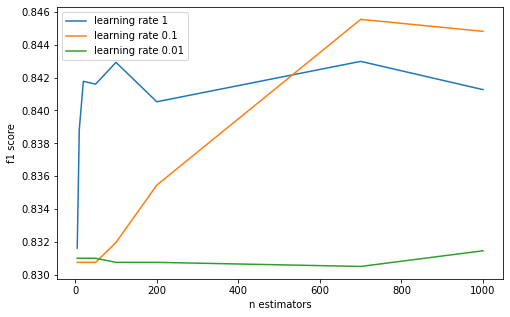

In [23]:
scores1 = np.array([[x[0], x[-1]] for x in scores if x[1] == 1])
scores2 = np.array([[x[0], x[-1]] for x in scores if x[1] == 0.1])
scores3 = np.array([[x[0], x[-1]] for x in scores if x[1] == 0.01])

fig = plt.figure(figsize=(8, 5))

plt.plot(scores1[:, 0], scores1[:, 1])
plt.plot(scores2[:, 0], scores2[:, 1])
plt.plot(scores3[:, 0], scores3[:, 1])

plt.xlabel('n estimators')
plt.ylabel('f1 score')
plt.legend(['learning rate 1', 'learning rate 0.1', 'learning rate 0.01'])

plt.show()

**Задание 3.** Вам потребуется обучить 4 модели и посчитать метрику f1-score на тестовой и обучающей выборках для каждой модели. 
1. Случайный лес с максимальной глубиной деревьев 5,
2. Случайный лес с максимальной глубиной деревьев 5000,
3. Градиентный бустинг с максимальной глубиной деревьев 5,
4. Градиентный бустинг с максимальной глубиной деревьев 5000.

Для каждой модели перебирайте значения `n_estimators`, как в предыдущем задании. Отрисуйте графики зависимости f1-score от количества шагов, используя `average='weighted'` для учёта баланса классов. 

Если в качестве базовой модели брать неглубокие деревья, то какая модель лучше запоминает обучающую выборку: случайный лес или градиентный бустинг? Какая из них лучше предсказывает на тестовой выборке? Как изменятся ответы, если базовая модель - это глубокое решающее дерево?

Подвержен ли переобучению случайный лес и градиентный бустинг? Как это отражается на графиках? (4б)

In [24]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

n_estimators_list = [2, 3, 4, 5, 10, 20, 50, 70, 100, 200, 700, 1000, 2000]

rf5_scores = []
rf5000_scores = []
gbm5_scores = []
gbm5000_scores = []

for n in n_estimators_list:
    
    rf5 = RandomForestClassifier(n_estimators=n, max_depth=5)
    rf5000 = RandomForestClassifier(n_estimators=n, max_depth=5000)
    
    gbm5 = GradientBoostingClassifier(n_estimators=n, max_depth=5)
    gbm5000 = GradientBoostingClassifier(n_estimators=n, max_depth=5000)
    
    rf5.fit(X_train, y_train)
    rf5000.fit(X_train, y_train)
    gbm5.fit(X_train, y_train)
    gbm5000.fit(X_train, y_train)
    
    rf5_scores.append(f1_score(y_test, rf5.predict(X_test), average='weighted'))
    rf5000_scores.append(f1_score(y_test, rf5000.predict(X_test), average='weighted'))
    gbm5_scores.append(f1_score(y_test, gbm5.predict(X_test), average='weighted'))
    gbm5000_scores.append(f1_score(y_test, gbm5000.predict(X_test), average='weighted'))

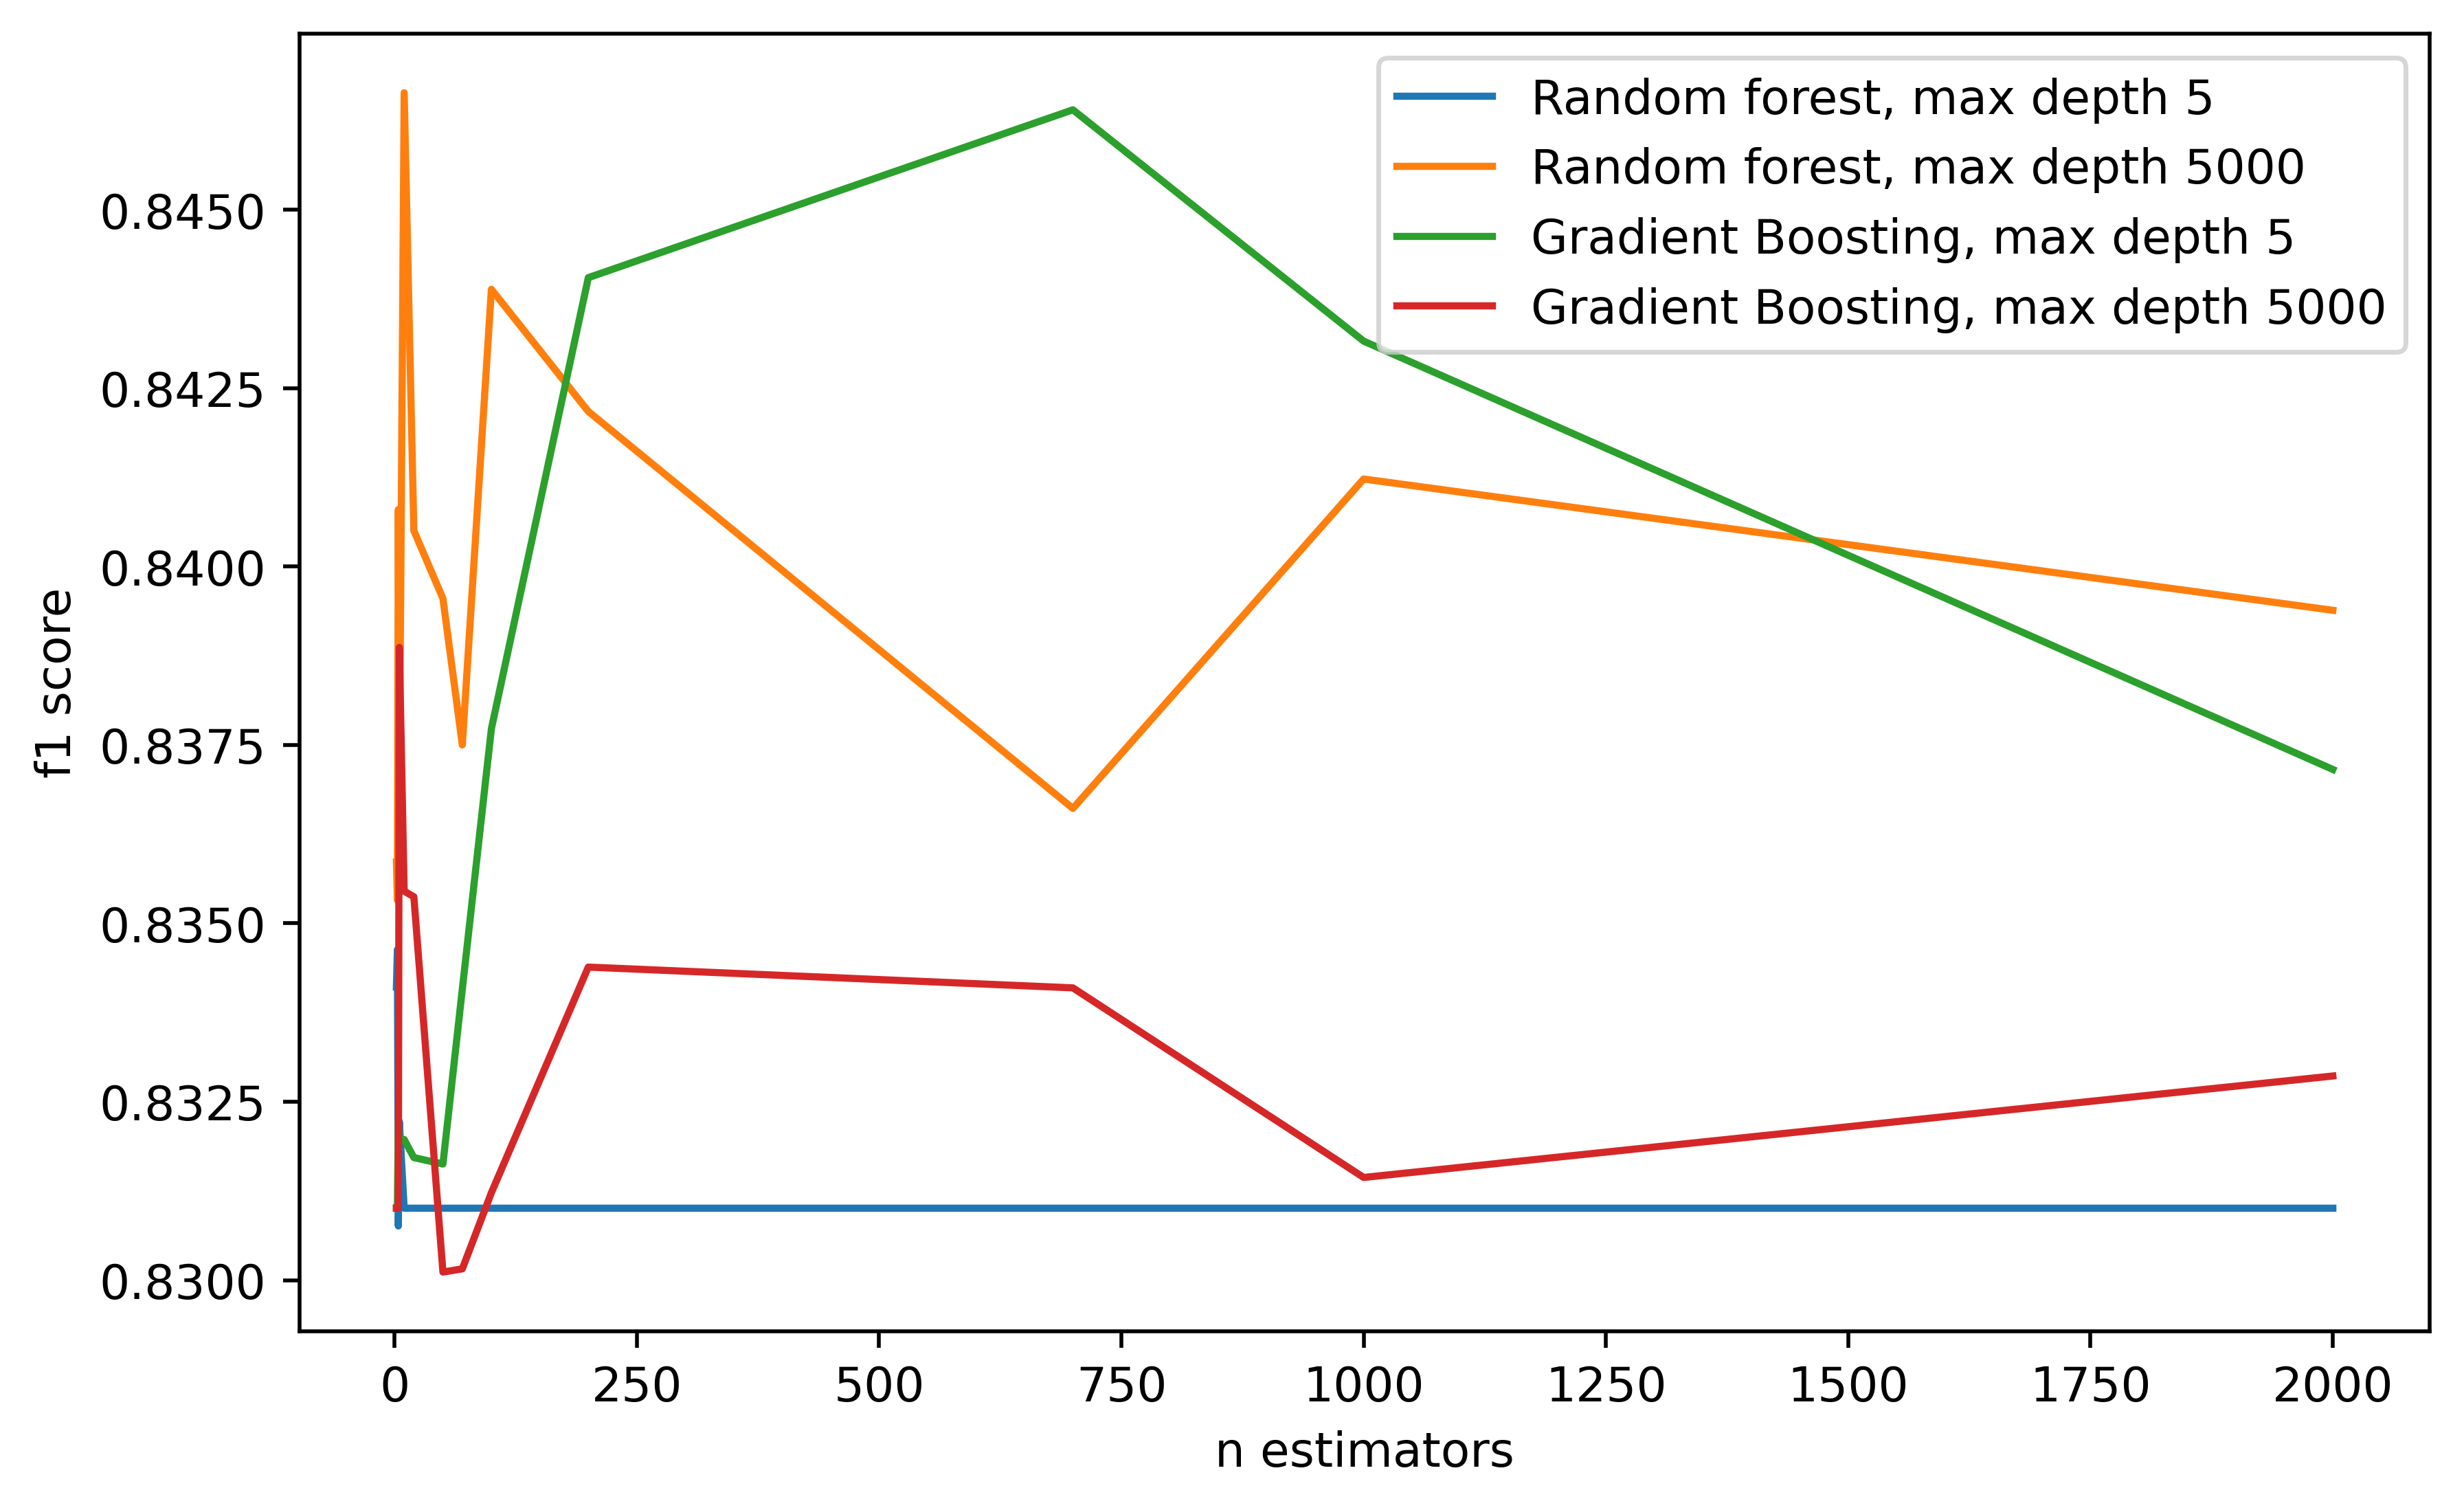

In [25]:
fig = plt.figure(dpi=500)

plt.plot(n_estimators_list, rf5_scores)
plt.plot(n_estimators_list, rf5000_scores)
plt.plot(n_estimators_list, gbm5_scores)
plt.plot(n_estimators_list, gbm5000_scores)

plt.xlabel('n estimators')
plt.ylabel('f1 score')
plt.legend(['Random forest, max depth 5', 'Random forest, max depth 5000',
            'Gradient Boosting, max depth 5', 'Gradient Boosting, max depth 5000'])

plt.show()

**Задание 4.** Установите библиотеку `catboost`. Главной особенностью catboost явялется наличие встроенной обработки категориальных признаков. Для каждого категориального столбца вычисляется следующее значение
$$
avg\_target = \dfrac{countInClass + prior}{totalCount + 1},
$$
* countInClass - количество объектов положительного класса для данной категории **до текущего объекта**,
* prior - некоторая константа для числителя, обычно равна доле положительного класса в таргете,
* totalCount - количество наблюдаемых категорий вплоть **до текущего** с той же категорией, что и у текущего.

Так как первые такие значения будут иметь больший разброс, чем последние, то выборку перемешивают несколько раз и полученные статистики усредняют. 
В отличие от target encoder подсчитанные значения зависят от наблюдаемой истории, т.е. вычисляются только из наблюдений до них, таким образом не происходит target leakage. 

Почитать подробнее можно здесь: [Transforming categorical features](https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic)

Обучите CatBoostClassifier с дефолтными параметрами. Используйте датасет до  (разбейте на train/test по старой логике с тем же random state'ом). Категориальные колонки передайте в параметр `cat_features` метода `fit`. Catboost сам с ними разберется.

Сравните качество с моделью из предыдущего задания. Стало ли лучше?

Сравните feature importances в модели из задания 2 и в catboost с помощью соответствующих методов, изобразите их, используя `barplot`. \
Какие признаки стали более важными с новым методом кодирования? (4б)

In [26]:
data2 = pd.read_csv('vehicle_insurance.csv')

X_2 = data2.drop('Response', axis=1)
y_2 = data2['Response']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2,
                                                            random_state=0, shuffle=True)

In [27]:
cat_features = object_cols.to_list()
cat_features

['Gender', 'Vehicle_Age', 'Vehicle_Damage']

In [28]:
from catboost import CatBoostClassifier

cat_gbm = CatBoostClassifier()
cat_gbm.fit(X_train_2, y_train_2,
            cat_features=cat_features,
            verbose=False)

In [29]:
print(classification_report(y_test_2, cat_gbm.predict(X_test_2), digits=3))

              precision    recall  f1-score   support

           0      0.889     0.986     0.935      1770
           1      0.342     0.057     0.097       230

    accuracy                          0.879      2000
   macro avg      0.616     0.521     0.516      2000
weighted avg      0.826     0.879     0.839      2000



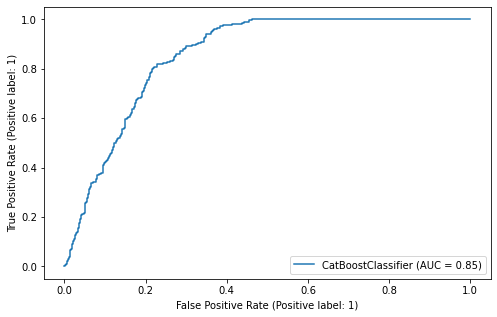

In [30]:
RocCurveDisplay.from_estimator(cat_gbm, X_test_2, y_test_2)
plt.show()

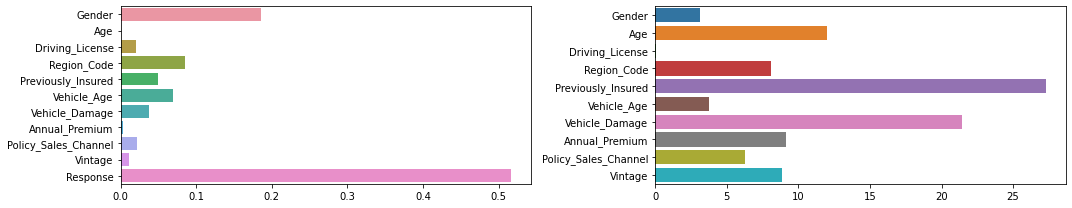

In [32]:
fig = plt.figure(figsize=(15, 3))

plt.subplot(1, 2, 1)
sns.barplot(x=gbm.feature_importances_, y=data2.columns)

plt.subplot(1, 2, 2)
sns.barplot(x=cat_gbm.feature_importances_, y=X_2.columns)

plt.tight_layout()

**Задание 5.** Установите библиотеку `lightgbm`. На сегодняшний день это наиболее быстрый метод градиентного бустинга, при этом расходующий небольшое количество оперативной памяти. Достигает он этого за счет построения деревьев вглубь по листьям (leaf-wise), а не по уровням (level-wise), как другие методы, например XGBoost. 
Более понятно это на картинке:

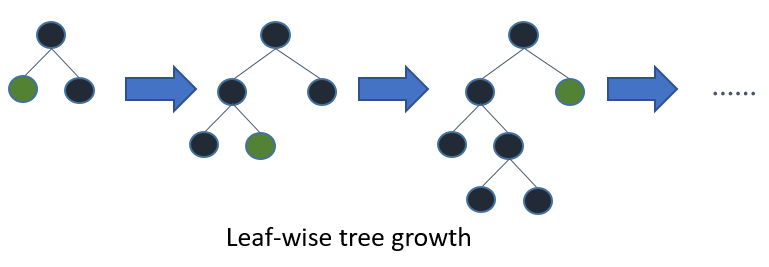

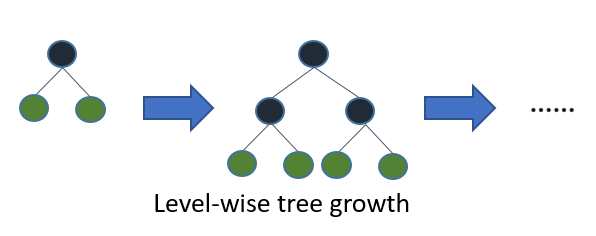

В то время, как XGBoost за раз разделяет вершины на целом уровне той же глубины, LightGBM разделяет одну вершину за раз. Отсюда прирост в скорости.

Обучите `LGBMClassifier` на изначальных(закодированных) данных и добейтесь максимального качества на тестовой выборке, перебрав параметры глубины деревьев, количества шагов, скорости обучения и т.д.

In [33]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [100, 500, 1000, 2000],
          'max_depth': [2, 3, 5, 100],
          'learning_rate': [0.1, 0.01, 0.001]}

light_gbm = LGBMClassifier()
light_gbm.fit(X_train, y_train)

LGBMClassifier()

In [34]:
print(classification_report(y_test, light_gbm.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.891     0.977     0.932      1770
           1      0.322     0.083     0.131       230

    accuracy                          0.875      2000
   macro avg      0.607     0.530     0.532      2000
weighted avg      0.826     0.875     0.840      2000



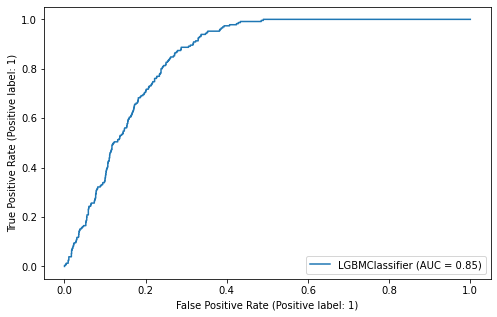

In [35]:
RocCurveDisplay.from_estimator(light_gbm, X_test, y_test)
plt.show()

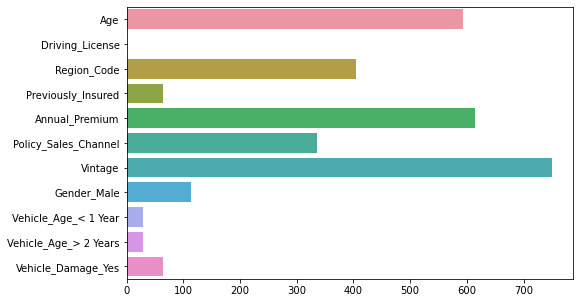

In [36]:
sns.barplot(x=light_gbm.feature_importances_, y=X.columns)
plt.show()

In [37]:
search = GridSearchCV(light_gbm, params)

search.fit(X_train, y_train)

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [2, 3, 5, 100],
                         'n_estimators': [100, 500, 1000, 2000]})

In [38]:
print(classification_report(y_test, search.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.885     1.000     0.939      1770
           1      0.000     0.000     0.000       230

    accuracy                          0.885      2000
   macro avg      0.443     0.500     0.469      2000
weighted avg      0.783     0.885     0.831      2000

